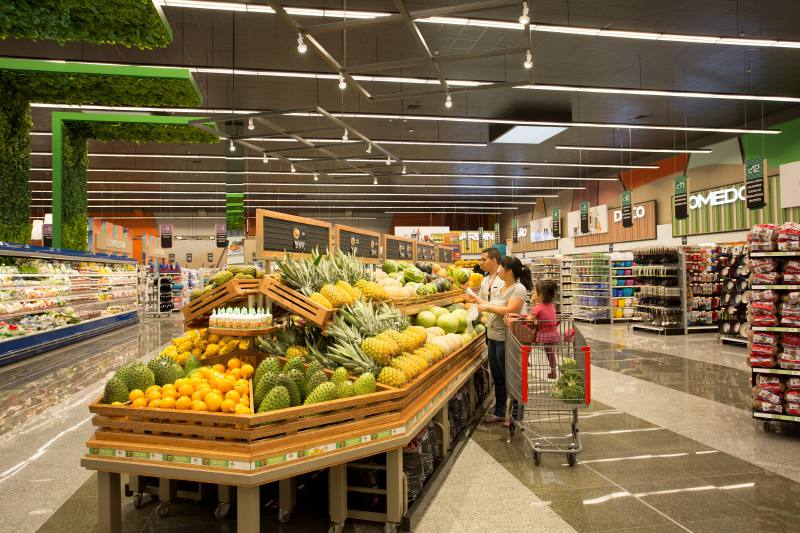

# Forecasting Favorita Store Sales using Machine Learning

<a name="table"></a> PROJECT CONTENTS

[1. Introduction](#intro)

[2. Exploratory Data Analysis](#eda)

[3. Feature Engineering](#fe)

[4. Evaluation Metrics](#eval)

[5. Machine Learning Model Selection](#ml)

[6. Tune Hyperparameters](#hyper)

[7. Exponentianal Moving Average](#ema)

[8. Conclusion](#concl)

[9. Summary](#sum)

[10. References](#ref)

## <a name="intro"></a> I. Introduction

[Favorita Corporation](https://www.corporacionfavorita.com/en/) develops commercial, industrial and real estate areas, present in Ecuador and 6 other countries in the region. They opened La Favorita supermarkets in country called Ecudor in South America which was the first self-service store in 1957.


In this project we’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. Kaggle has published a knowledge based compitition to predict store sales by providing Favorita Corporation Stores data. 
[Learn more](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

### Loading Data

In [3]:
# Downloading Data
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [5]:
Kaggle_url = 'https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data'
od.download(Kaggle_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pratulperla
Your Kaggle Key: ··········


100%|██████████| 21.4M/21.4M [00:00<00:00, 123MB/s] 


Extracting archive ./store-sales-time-series-forecasting/store-sales-time-series-forecasting.zip to ./store-sales-time-series-forecasting


In [6]:
import os
os.listdir("store-sales-time-series-forecasting")

['sample_submission.csv',
 'train.csv',
 'holidays_events.csv',
 'stores.csv',
 'oil.csv',
 'test.csv',
 'transactions.csv']

In [7]:
import glob
path = './store-sales-time-series-forecasting'
glob.glob(path+"/"+"*.csv")

['./store-sales-time-series-forecasting/sample_submission.csv',
 './store-sales-time-series-forecasting/train.csv',
 './store-sales-time-series-forecasting/holidays_events.csv',
 './store-sales-time-series-forecasting/stores.csv',
 './store-sales-time-series-forecasting/oil.csv',
 './store-sales-time-series-forecasting/test.csv',
 './store-sales-time-series-forecasting/transactions.csv']

In [8]:
import pandas as pd

train_df = pd.read_csv('./store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('./store-sales-time-series-forecasting/test.csv')
stores_df = pd.read_csv('./store-sales-time-series-forecasting/stores.csv')
holidays_df = pd.read_csv('./store-sales-time-series-forecasting/holidays_events.csv')
transactions_df = pd.read_csv('./store-sales-time-series-forecasting/transactions.csv')
oil_df = pd.read_csv('./store-sales-time-series-forecasting/oil.csv')
sample_sub_df = pd.read_csv('./store-sales-time-series-forecasting/sample_submission.csv')

In [9]:
train_df.shape, train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


((3000888, 6), None)

In [10]:
test_df.shape, test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


((28512, 5), None)


#### Data Info

* There are 33 product families in 54 stores that are categorized into 5 types of stores A, B, C, D, E and 17 clusters, is a grouping of similar stores across 22 cities from 16 states.

### Data Cleaning

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
print("****************************training_df\n", train_df.isna().sum())
print("****************************stores_df\n",stores_df.isna().sum())
print("****************************holidays_df\n",holidays_df.isna().sum())
print("****************************transactions_df\n",transactions_df.isna().sum())
print("****************************test_df\n",test_df.isna().sum())
print("****************************oil_df\n",oil_df.isna().sum())

****************************training_df
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
****************************stores_df
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
****************************holidays_df
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
****************************transactions_df
 date            0
store_nbr       0
transactions    0
dtype: int64
****************************test_df
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
****************************oil_df
 date           0
dcoilwtico    43
dtype: int64


Here in the oil data containes some NaN values. My strategy is replacing it by taking a mean value of upper and lower row values of a NaN value row.

In [13]:
import numpy as np
oil_df.dcoilwtico[0]=93.00

In [14]:
for i in list(oil_df[oil_df.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([oil_df.dcoilwtico[p],oil_df.dcoilwtico[c]])
  oil_df.dcoilwtico[i]=mean

In [15]:
oil_df[oil_df.dcoilwtico.isna()]

date  dcoilwtico
1174  2017-07-03         NaN
1175  2017-07-04         NaN

In [16]:
print(oil_df.loc[1173])
oil_df.dcoilwtico[1174]=46.02
oil_df.dcoilwtico[1175]=46.02

date          2017-06-30
dcoilwtico         46.02
Name: 1173, dtype: object


### Data Manipulation

In [17]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
holidays_df["date"] = pd.to_datetime(holidays_df["date"])

In [18]:
final_train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')
final_test_df = pd.merge(test_df, stores_df, on='store_nbr', how='left')
final_train_df = pd.merge(final_train_df, oil_df, on='date', how='left')
final_test_df = pd.merge(final_test_df, oil_df, on='date', how='left')

In [19]:
holidays_df.rename(columns = {'locale_name':'city', 'type': 'day_type'},inplace=True)
holidays_df.drop('description',axis=1,inplace=True)

In [20]:
final_train_df = pd.merge(final_train_df, holidays_df, on=['date','city'], how='left')
final_test_df = pd.merge(final_test_df, holidays_df, on=['date','city'], how='left')

In [21]:
# Apart from holidays all are working days
final_train_df['day_type'].fillna('working_day',inplace=True)
final_test_df['day_type'].fillna('working_day',inplace=True)
# Filling the blanks with the value before nan
final_train_df['dcoilwtico'].fillna(method = 'ffill', inplace=True)
final_test_df['dcoilwtico'].fillna(method = 'ffill', inplace=True)
# All the NaN value in 'locale' column are working days hence it is National
final_train_df['locale'].fillna('National', inplace=True)
final_test_df['locale'].fillna('National', inplace=True)
# All the NaN values are working days hence not tranferred
final_train_df['transferred'].fillna(False, inplace=True)
final_test_df['transferred'].fillna(False, inplace=True)

final_train_df.rename(columns = {'type': 'store_type'},inplace=True)
final_test_df.rename(columns = {'type': 'store_type'},inplace=True)

In [22]:
def replace_fam_vals(df):
  df.replace('HOME APPLIANCES','HOME_APPLIANCES',inplace=True)
  df.replace('BABY CARE','BABY_CARE',inplace=True)
  df.replace('BREAD/BAKERY','BREAD_BAKERY',inplace=True)
  df.replace('FROZEN FOODS','FROZEN_FOODS',inplace=True)
  df.replace('GROCERY I','GROCERY_I',inplace=True)
  df.replace('GROCERY II','GROCERY_II',inplace=True)
  df.replace('HOME AND KITCHEN I','HOME_AND_KITCHEN_I',inplace=True)
  df.replace('HOME AND KITCHEN II','HOME_AND_KITCHEN_II',inplace=True)
  df.replace('HOME CARE','HOME_CARE',inplace=True)
  df.replace('LAWN AND GARDEN','LAWN_AND_GARDEN',inplace=True)
  df.replace('LIQUOR,WINE,BEER','LIQUOR_WINE_BEER',inplace=True)
  df.replace('PERSONAL CARE','PERSONAL_CARE',inplace=True)
  df.replace('PET SUPPLIES','PET_SUPPLIES',inplace=True)
  df.replace('PLAYERS AND ELECTRONICS','PLAYERS_AND_ELECTRONICS',inplace=True)
  df.replace('PREPARED FOODS','PREPARED_FOODS',inplace=True)
  df.replace('SCHOOL AND OFFICE SUPPLIES','SCHOOL_AND_OFFICE_SUPPLIES',inplace=True)
  return df

In [23]:
replace_fam_vals(final_train_df.family)
replace_fam_vals(final_test_df.family)

0                        AUTOMOTIVE
1                         BABY_CARE
2                            BEAUTY
3                         BEVERAGES
4                             BOOKS
                    ...            
28507                       POULTRY
28508                PREPARED_FOODS
28509                       PRODUCE
28510    SCHOOL_AND_OFFICE_SUPPLIES
28511                       SEAFOOD
Name: family, Length: 28512, dtype: object

In [24]:
final_train_df['store_nbr']= final_train_df['store_nbr'].astype('uint8')
final_train_df['sales']= final_train_df['sales'].astype('float64')
final_train_df['onpromotion']= final_train_df['onpromotion'].astype('uint16')
final_train_df['cluster']= final_train_df['cluster'].astype('uint8')
final_train_df['dcoilwtico']= final_train_df['dcoilwtico'].astype('float64')
final_train_df['transferred'] = final_train_df['transferred'].astype('uint8')
############
final_test_df['store_nbr']= final_test_df['store_nbr'].astype('uint8')
final_test_df['onpromotion']= final_test_df['onpromotion'].astype('uint16')
final_test_df['cluster']= final_test_df['cluster'].astype('uint8')
final_test_df['dcoilwtico']= final_test_df['dcoilwtico'].astype('float64')
final_test_df['transferred'] = final_test_df['transferred'].astype('uint8')

In [25]:
final_train_df.shape, final_test_df.shape

((3001152, 14), (28512, 13))

Finally we've ended up with 

> 3M+ rows 14 features of train data from 2013-01-01 to 2017-08-15

> 28K+ rows 13 features of test data from 2017-08-16 to 2017-08-31

## <a name="eda"></a> II. Exploratory Data Analysis

In [26]:
!pip install seaborn plotly --upgrade --quiet
!pip install matplotlib==3.1.3 --quiet

     |████████████████████████████████| 288 kB 5.2 MB/s 
     |████████████████████████████████| 15.3 MB 68.1 MB/s 
     |████████████████████████████████| 13.1 MB 5.0 MB/s 


In [27]:
# Visualisation libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
%matplotlib inline

#### NaN values in Oil data

In [28]:
oil_df1 = pd.read_csv('./store-sales-time-series-forecasting/oil.csv')
fig,axes = plt.subplots(1,2,figsize= (14,5))
oil_df1['dcoilwtico'].plot(ax=axes[0])
oil_df['dcoilwtico'].plot(ax=axes[1])
axes[0].set_title("Before")
axes[1].set_title("After")

fig.suptitle("NaN values in Oil Prices Dataframe")
sns.despine();

#### Did Earhquake affect the store sales?


There's an additional note about the data

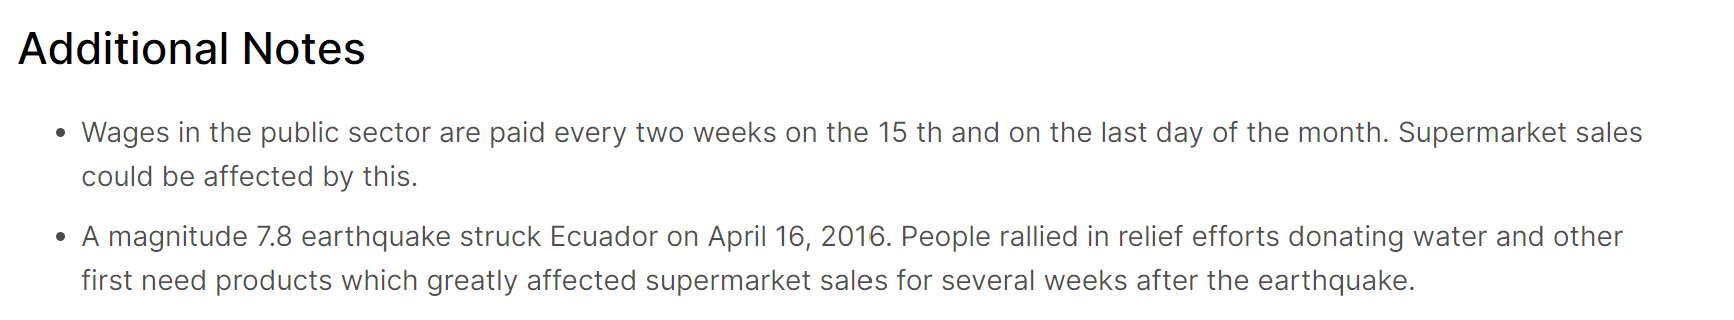

In [29]:
# March
march= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([3]))], 
               index=final_train_df.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
march

family  AUTOMOTIVE  BABY_CARE    BEAUTY    BEVERAGES     BOOKS  BREAD_BAKERY  \
date                                                                           
2013      4.560932   0.000000  2.330346  1088.542413  0.000000    354.853526   
2014      6.042413   0.043011  3.086022  2646.471924  0.000000    388.987692   
2015      6.902031   0.000000  2.538232  1385.922342  0.000000    500.669417   
2016      7.203106   0.264038  4.261051  2967.511947  0.000000    492.651516   
2017      7.642772   0.264038  4.212067  3664.010155  0.281959    573.421241   

family  CELEBRATION     CLEANING       DAIRY        DELI  ...  MAGAZINES  \
date                                                      ...              
2013       0.000000   899.277180  365.894863  195.494296  ...   0.000000   
2014      12.830346  1057.511350  709.575269  227.415349  ...   1.170251   
2015       0.000000  1115.107527  737.664875  301.454903  ...   0.000000   
2016      13.970131  1057.762843  843.405018  272.667234  ...   5.959976   
2017      13.947431  1197.510753  972.788530  320.441513  ...   6.161888   

family       MEATS  PERSONAL_CARE  PET_SUPPLIES  PLAYERS_AND_ELECTRONICS  \
date                                                                       
2013    313.938676     190.713262      0.000000                 0.000000   
2014    332.993349     231.297491      4.785544                 9.594385   
2015    326.473811     289.569892      0.000000                 0.000000   
2016    324.644176     290.982676      5.780765                 8.557945   
2017    367.350973     325.296894      8.627838                11.180406   

family     POULTRY  PREPARED_FOODS      PRODUCE  SCHOOL_AND_OFFICE_SUPPLIES  \
date                                                                          
2013    190.441733       90.362182     2.411589                    0.000000   
2014    390.943043       97.848576  2002.596327                    1.335125   
2015    384.931138       95.655186     4.124851                    0.000000   
2016    368.022836      107.821004  2262.134630                    1.922342   
2017    388.023902      111.916694  2396.963142                    4.925926   

family    SEAFOOD  
date               
2013    23.941057  
2014    23.890751  
2015    26.169936  
2016    23.449707  
2017    25.063907  

[5 rows x 33 columns]

In [30]:
march= march.sum(axis=1).reset_index()
march['month']= 'march'

In [31]:
# April
april= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([4]))], 
               index=final_train_df.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
april

family  AUTOMOTIVE  BABY_CARE    BEAUTY    BEVERAGES     BOOKS  BREAD_BAKERY  \
date                                                                           
2013      4.620370   0.000000  2.265432  1076.000617  0.000000    351.001987   
2014      5.201235   0.000000  2.394444  1304.398148  0.000000    353.837909   
2015      5.584568   0.000000  2.467901  1424.164815  0.000000    493.748901   
2016      7.179630   0.225309  5.119136  3515.125926  0.000000    527.641915   
2017      8.129012   0.183951  4.622840  3660.164815  0.159259    541.994005   

family  CELEBRATION     CLEANING       DAIRY        DELI  ...  MAGAZINES  \
date                                                      ...              
2013       0.000000   877.300000  345.425926  195.162783  ...   0.000000   
2014       0.000000   896.440741  678.221605  215.213918  ...   0.000000   
2015       0.000000  1129.893210  729.123457  296.434968  ...   1.345679   
2016      14.203704  1224.717284  880.954321  293.728508  ...   6.930247   
2017      13.957407  1246.548148  964.040123  320.071472  ...   7.022840   

family       MEATS  PERSONAL_CARE  PET_SUPPLIES  PLAYERS_AND_ELECTRONICS  \
date                                                                       
2013    321.711827     201.569753      0.000000                 0.000000   
2014    302.611760     225.521605      0.000000                 0.000000   
2015    322.410050     280.970988      0.000000                 0.000000   
2016    360.285461     383.485802      6.767284                11.470988   
2017    352.594988     338.188889      9.053086                12.250617   

family     POULTRY  PREPARED_FOODS      PRODUCE  SCHOOL_AND_OFFICE_SUPPLIES  \
date                                                                          
2013    188.420076       80.945479     3.893827                    0.000000   
2014    347.227843       92.550206     4.414815                    0.000000   
2015    372.965106       95.475383     4.421605                    0.000000   
2016    398.568723      108.636610  2235.387336                    5.524691   
2017    373.529996      100.449227  2319.168684                   17.709259   

family    SEAFOOD  
date               
2013    21.172472  
2014    19.701996  
2015    24.681155  
2016    24.292264  
2017    22.359186  

[5 rows x 33 columns]

In [32]:
april= april.sum(axis=1).reset_index()
april['month']= 'april'

In [33]:
# May
may= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([5]))], 
               index=final_train_df.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
may

family  AUTOMOTIVE  BABY_CARE    BEAUTY    BEVERAGES   BOOKS  BREAD_BAKERY  \
date                                                                         
2013      5.396655   0.000000  2.219833  1089.679211  0.0000    368.008156   
2014      4.823775   0.000000  2.163680  1243.594982  0.0000    371.376630   
2015      5.572879   0.000000  3.011947  2111.170848  0.0000    527.189014   
2016      7.072282   0.271804  4.456392  3105.347073  0.0000    555.272169   
2017      7.059737   0.166667  5.900239  3487.099761  0.0908    566.843280   

family  CELEBRATION     CLEANING       DAIRY        DELI  ...  MAGAZINES  \
date                                                      ...              
2013       0.000000   887.870370  355.828554  207.463181  ...   0.000000   
2014       0.000000   895.068100  658.005974  226.424023  ...   0.000000   
2015       0.000000  1143.790323  772.585424  314.021200  ...   1.768220   
2016      13.768817  1167.784349  908.533453  293.746375  ...   6.377539   
2017      13.338112  1352.649940  966.421147  322.572431  ...   6.640980   

family       MEATS  PERSONAL_CARE  PET_SUPPLIES  PLAYERS_AND_ELECTRONICS  \
date                                                                       
2013    327.053195     184.580048      0.000000                 0.000000   
2014    327.115551     238.545998      0.000000                 0.000000   
2015    353.459916     300.913381      0.111111                 0.000000   
2016    353.364833     330.847073      6.666667                 9.504779   
2017    367.788181     310.506571      8.976703                12.050777   

family     POULTRY  PREPARED_FOODS      PRODUCE  SCHOOL_AND_OFFICE_SUPPLIES  \
date                                                                          
2013    192.131831       85.046085     5.278375                    0.000000   
2014    358.785254       87.823661     5.432497                    0.000000   
2015    396.078818       94.243751     6.076464                    0.000000   
2016    385.590510      104.735601  2289.723186                    6.228793   
2017    392.489781       91.215556  2460.593033                    5.769415   

family    SEAFOOD  
date               
2013    22.376498  
2014    21.444462  
2015    25.392373  
2016    23.906000  
2017    23.695576  

[5 rows x 33 columns]

In [34]:
may= may.sum(axis=1).reset_index()
may['month']= 'may'

In [35]:
ee= march.append(april).append(may).reset_index().drop(['index'], axis=1)
trace1 = go.Bar(x=ee.date, y=ee[0][ee.month=='march'],
                marker=dict(color='#bbe070'),
                name='March')
trace2 = go.Bar(x=ee.date, y=ee[0][ee.month=='april'],
                marker=dict(color='#f77e90'),
                name='April')
trace3 = go.Bar(x=ee.date, y=ee[0][ee.month=='may'],
                marker=dict(color='#bbe070'),
                name='May')
data = [trace1, trace2, trace3]

fig = go.Figure(data = data)
fig.layout.update({'title': 'Earthquake Effect On Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_layout(title_x=0.5)
fig.show()

* There is an increase in April's sales in 2016

* By comparing all the years groceries always made sales high. 

#### Top 10 Products


In [52]:
df_fa_sa = final_train_df.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales',
                                                                                              ascending=False)[:15]                                                                                         
df_fa_sa['color'] = '#71c7ec'
df_fa_sa['color'][2:] = '#107dac'

trace= go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'],
               marker=dict(color= df_fa_sa['color']),
               name='Family', orientation='h')

fig = go.Figure(data = trace)
fig.layout.update({'title': 'Top 10 Product Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending')
fig.update_xaxes(visible=False)
fig.update_layout(title_x=0.5)
fig.show()

* Highest sales are made by the products like grocery and beverages.

#### Average Sales Distribution

In [59]:
avg_sd = final_train_df.groupby([final_train_df.date.dt.year, 
                                 "store_type"]).agg({"sales":"mean"}).sort_values('store_type', 
                                                                                  ascending=True).reset_index()
fig = px.box(avg_sd, y="sales", facet_col="store_type",
             color= 'store_type',
             boxmode="overlay", points='all')

fig.layout.update({'width':700,'height':500})
fig.update_layout(title = "Average Sales Distribution")
fig.update_layout(title_x=0.3)
fig.show()

* Store A has highest sales with the median of 719.7. Store A has the highest sales which is 38%.

* A > D > B > E > C this is the ranking of store types considering medians of sales.


#### Average Sales by Month

In [54]:
final_train_df['Year'] = final_train_df['date'].dt.year
final_train_df['Month'] = final_train_df['date'].dt.month
def convert_to_size(x):
    if x < 50:
        return 6
    elif x < 100:
        return 10
    elif x < 150:
        return 15
    elif x < 250:
        return 18 
    elif x < 300:
        return 24 
    elif x < 500:
        return 30 
    else:
        return 40

def bubble(col1, col2):
    vc = final_train_df.groupby([col1, col2]).agg({"sales" : "mean"}).reset_index()
    vc = vc.sort_values(col2)    
    fig = px.scatter(vc, x=col1, y=col2, 
                     size='sales',color='sales', 
                     color_continuous_scale=px.colors.diverging.BrBG,
                     size_max=40)
    fig.update_layout(title = "Average Sales by "+col1+" and " + col2)
    fig.update_layout({'width':800,'height':400})
    fig.update_layout(title_x=0.2)
    fig.show()

In [55]:
bubble('Month', 'day_type')
bubble('Month', 'store_type')

* Every store type has peak sales in Christmas season i.e 12th month.

#### Product Family Monthly sales

In [56]:
fig= plt.figure(figsize=(20,120))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(final_train_df.family.unique()):
    ax = fig.add_subplot(33,2,i+1)
    select = final_train_df.query('family==@product')
    for year in [2013,2014,2015,2016,2017]: 
        select.query('Year==@year').groupby('Month').sales.mean().plot(ax=ax,label=year)
    plt.title(product)
    ax.legend();

#### Transactions trends for each Store

In [60]:
fig= plt.figure(figsize=(20,100))
fig.subplots_adjust(hspace=0.75)
for i,store in enumerate(range(1,54)):
    ax = fig.add_subplot(14,4,i+1)
    transactions_df.set_index('date').query('store_nbr==@store').transactions.plot(c='blue');
    plt.title('Store Number: ' + str(store));
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45);

All the stores are clearly having a pattern and almost same amount of transactions. Every december (Christmas season) have the most transactions.

#### Number of Stores in each City

In [61]:
ex_df = stores_df.groupby(['city', 'type']).count()[['store_nbr']].reset_index(level=0).reset_index(level=0)[['city', 'type', 'store_nbr']]
map_colors = {'A': '#96ceb4', 'B':'#ffeead', 'C':'#ffcc5c', 'D':'#ff6f69', 'E':'#ffff99'}
ex_df['colors'] = ex_df['type'].map(map_colors)

#SALES 
trace= go.Bar(y=ex_df['store_nbr'],
              x=ex_df['city'],
              text = ex_df["type"],
              marker=dict(color= ex_df['colors']))

##styling 
fig = go.Figure(data = trace)
fig.update_xaxes(visible=True)
fig.layout.update({'title': 'Number of Stores in each City by Type'})
fig.update_yaxes(showgrid=False)
fig.update_layout(title_x=0.5,
                  template="ggplot2",
                  bargap=0.4,
                  height=700,
                  width=800,
                  showlegend=False)

fig.show()

#### Data available in each year

In [62]:
plt.figure(figsize=(8, 8))
sns.countplot(x=pd.to_datetime(final_train_df.date).dt.year)
plt.title('No. of Rows per Year')
plt.show();

#### Correlations

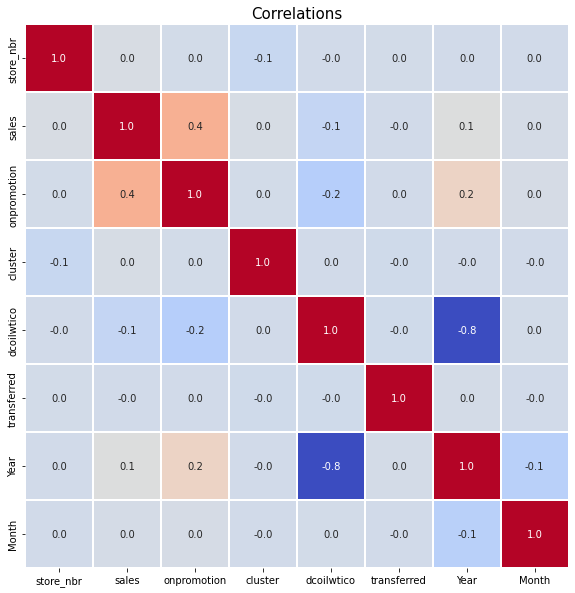

In [63]:
plt.figure(figsize=(10, 10))
sns.heatmap(final_train_df[final_train_df.columns[1:]].corr(),
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        linewidths=1,
        cbar=False)
plt.title("Correlations",fontsize = 15)
plt.show()

We can clearly see there are no columns that are correlated each other except `dcoilwtico` and `year`.

Refer to this [page](https://rpubs.com/yongks/favorita) to find out more about the data.

## <a name="fe"></a> III. Feature Engineering

#### Date Features

In [66]:
def create_date_features(df):
    df['WeekofYear'] = (df['date'].dt.isocalendar().week)
    df['Year'] = df['date'].dt.year
    df['Day'] = df['date'].dt.day
    df['Month'] = df['date'].dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_week'] = df.date.dt.dayofweek

    df['WeekofYear']= df['WeekofYear'].astype('uint8')
    df['Month'] = df['Month'].astype('uint8')
    df['Year'] = df['Year'].astype('uint16')
    df['Day'] = df['Day'].astype('uint8')
    df['day_of_month'] = df['day_of_month'].astype('uint16')
    df['day_of_year'] = df['day_of_year'].astype('uint16')
    df['day_of_week'] = df['day_of_week'].astype('uint16')         
    return df

In [67]:
final_train_df = create_date_features(final_train_df)
final_test_df = create_date_features(final_test_df)

#### Scaling & Onehot Encoding

In [68]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# Input and target columns

input_cols= ['onpromotion','cluster','dcoilwtico',
             'family', 'city', 'state', 'store_type', 
             'day_type', 'locale']
input_cols1= ['family', 'onpromotion', 'city', 
              'state', 'type', 'cluster','dcoilwtico']
# Non Scaling cols
transferred= ['transferred']
store_nbr= ['store_nbr']
dates = ['WeekofYear','Month','Year','Day', 
         'day_of_month','day_of_year','day_of_week', ]
target_col = 'sales'

In [69]:
inputs_df = final_train_df.copy()
targets_df = final_train_df[target_col].copy()
targets_df= targets_df

test_inputs_df = final_test_df.copy()

In [70]:
# Numerical and Categorical columns

numeric_cols = final_train_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = final_train_df[input_cols].select_dtypes(include='object').columns.tolist()

In [71]:
# Scaling numeric columns

scaler = MinMaxScaler().fit(inputs_df[numeric_cols])

inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])
test_inputs_df[numeric_cols] = scaler.transform(test_inputs_df[numeric_cols])

In [72]:
# One-hot encode categorical columns

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])

encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [73]:
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
inputs_df[encoded_cols]=inputs_df[encoded_cols].astype('uint8')
test_inputs_df[encoded_cols] = encoder.transform(test_inputs_df[categorical_cols])
test_inputs_df[encoded_cols]= test_inputs_df[encoded_cols].astype('uint8')

#### Creating Train / Validation Datasets

In [74]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[dates + store_nbr + transferred + numeric_cols + encoded_cols], 
    targets_df, test_size=0.10, random_state=42)

In [75]:
#train_inputs, val_inputs
#train_targets, val_targets

Train : 90% , Validate: 10% 

In [76]:
X_test = test_inputs_df[dates + transferred + store_nbr + numeric_cols + encoded_cols]

Kaggle already gave us splitted data as train and test.

## <a name="eval"></a> IV. Evaluation Metric

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:

$$RMSLE = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$$

where:

 $n$ is the total number of instances,

 $\hat{y}_i$ is the predicted value of the target for instance (i),

 ${y}_i$ is the actual value of the target for instance (i)
 
 $log$ is the natural logarithm.

In [77]:
#Helper function for evaluation metric
from sklearn.metrics import mean_squared_log_error
pd.options.display.float_format = '{:,.2f}'.format

def eval_metrics(targets, pred):

  # Targets = Train targets or Val targets (tarin_targets / val_targets)
  # pred = model predicts

   rmsle = round(mean_squared_log_error(targets, pred, squared= False),3)

   return {'RMSLE': rmsle}

## <a name="ml"></a> V. Machine Learning Modeling

### Base Model

In [78]:
base_model1 = final_train_df.groupby(['store_nbr','store_type']).sales.transform('median')
base_model2 = final_train_df.groupby(['store_nbr','store_type']).sales.transform('mean')
print(eval_metrics(final_train_df.sales, base_model1))
print(eval_metrics(final_train_df.sales, base_model2))

{'RMSLE': 2.671}
{'RMSLE': 3.794}


In [79]:
!pip install xgboost scikit-learn lightgbm --upgrade --quiet

     |████████████████████████████████| 255.9 MB 36 kB/s 
     |████████████████████████████████| 2.0 MB 41.3 MB/s 


In [80]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

### Linear Regression

In [81]:
%%time
linear_model= LinearRegression()
linear_model.fit(train_inputs, train_targets)

CPU times: user 42.5 s, sys: 6.71 s, total: 49.2 s
Wall time: 58.8 s


LinearRegression()

In [82]:
lm_t_preds = linear_model.predict(train_inputs)
lm_v_preds = linear_model.predict(val_inputs)
lm_t_preds[lm_t_preds<0]=0
lm_v_preds[lm_v_preds<0]=0

In [83]:
print("train_error", eval_metrics(train_targets, lm_t_preds))
print("val_error", eval_metrics(val_targets, lm_v_preds))

train_error {'RMSLE': 2.43}
val_error {'RMSLE': 2.425}


As expected the the model performed very poor and is underfitting because there is no linearity in the data. The less score in RMSLE is more accurate prediction.

### Ridge Regressor

In [84]:
%%time
from sklearn.linear_model import Ridge
rdg_model = Ridge()
rdg_model.fit(train_inputs, train_targets)

CPU times: user 4.03 s, sys: 12.4 ms, total: 4.05 s
Wall time: 4.86 s


Ridge()

In [85]:
rdg_t_preds = rdg_model.predict(train_inputs)
rdg_v_preds = rdg_model.predict(val_inputs)
rdg_t_preds[rdg_t_preds<0]=0
rdg_v_preds[rdg_v_preds<0]=0

In [86]:
print("train_error", eval_metrics(train_targets, rdg_t_preds))
print("val_error", eval_metrics(val_targets, rdg_v_preds))

train_error {'RMSLE': 2.43}
val_error {'RMSLE': 2.425}


### Decision Tree Regressor

In [87]:
%%time
dtree_model= DecisionTreeRegressor()
dtree_model.fit(train_inputs, train_targets)

CPU times: user 2min 24s, sys: 171 ms, total: 2min 24s
Wall time: 2min 40s


DecisionTreeRegressor()

In [145]:
dtm_t_preds = dtree_model.predict(train_inputs)
dtm_v_preds = dtree_model.predict(val_inputs)

In [146]:
print(dtree_model)
print('max_features',dtree_model.max_features_)
print('max_depthd',dtree_model.tree_.max_depth)
print('n_leaves',dtree_model.tree_.n_leaves)
print("train_error", eval_metrics(train_targets, dtm_t_preds))
print("val_error", eval_metrics(val_targets, dtm_v_preds))

DecisionTreeRegressor()
max_features 91
max_depthd 72
n_leaves 1849218
train_error {'RMSLE': 0.0}
val_error {'RMSLE': 0.643}


In [ ]:
dtree_test_preds = dtree_model.predict(X_test)
submission_df= pd.DataFrame({'id': final_test_df.id,
                            'sales':dtree_test_preds})
submission_df.to_csv('no_hp_dt_preds.csv',index=False)

The model remembered each and every entry and gave the outmost result. Out of 580+ teams my position was 430. Still we need to tune the models to get the results more accurate.

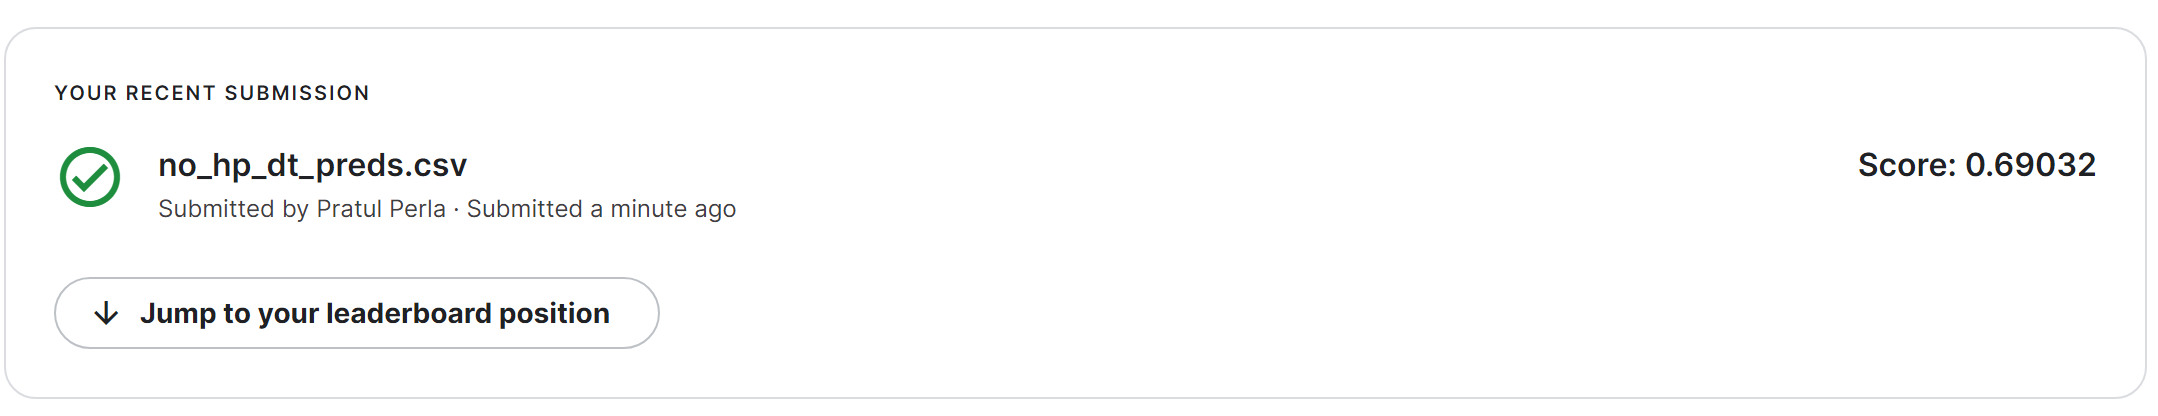

### XGBRegressor

In [68]:
#?XGBRegressor

In [67]:
%%time
xgb_model= XGBRegressor(random_state = 42, 
                        n_jobs = -1,max_depth=6, n_estimators=10)
xgb_model.fit(train_inputs, train_targets)

CPU times: user 4min 23s, sys: 4.62 s, total: 4min 27s
Wall time: 2min 44s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=10, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [69]:
xgbm_t_preds = xgb_model.predict(train_inputs)
xgbm_v_preds = xgb_model.predict(val_inputs)
xgbm_t_preds[xgbm_t_preds<0]=0
xgbm_v_preds[xgbm_v_preds<0]=0

In [70]:
print("train_error", eval_metrics(train_targets, xgbm_t_preds))
print("val_error", eval_metrics(val_targets, xgbm_v_preds))

train_error {'RMSLE': 2.46}
val_error {'RMSLE': 2.456}


### LightGBM

In [71]:
%%time
lgbm_model = LGBMRegressor(boosting_type='gbdt', 
                           num_leaves= 10000, learning_rate= 0.1,
                           max_depth= 10, n_estimators=100)
lgbm_model.fit(train_inputs, train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric='mse')
lgbm_t_preds = lgbm_model.predict(train_inputs, num_iteration=lgbm_model.best_iteration_)
lgbm_v_preds = lgbm_model.predict(val_inputs, num_iteration=lgbm_model.best_iteration_)

[1]	valid_0's l2: 1.00417e+06
[2]	valid_0's l2: 843909
[3]	valid_0's l2: 714145
[4]	valid_0's l2: 608728
[5]	valid_0's l2: 522706
[6]	valid_0's l2: 453086
[7]	valid_0's l2: 395383
[8]	valid_0's l2: 349252
[9]	valid_0's l2: 310631
[10]	valid_0's l2: 279819
[11]	valid_0's l2: 253999
[12]	valid_0's l2: 233208
[13]	valid_0's l2: 215510
[14]	valid_0's l2: 201204
[15]	valid_0's l2: 189424
[16]	valid_0's l2: 179429
[17]	valid_0's l2: 171116
[18]	valid_0's l2: 164287
[19]	valid_0's l2: 158221
[20]	valid_0's l2: 152921
[21]	valid_0's l2: 148465
[22]	valid_0's l2: 144973
[23]	valid_0's l2: 141761
[24]	valid_0's l2: 139313
[25]	valid_0's l2: 137146
[26]	valid_0's l2: 135089
[27]	valid_0's l2: 133184
[28]	valid_0's l2: 131444
[29]	valid_0's l2: 129921
[30]	valid_0's l2: 128363
[31]	valid_0's l2: 126793
[32]	valid_0's l2: 125864
[33]	valid_0's l2: 124546
[34]	valid_0's l2: 123515
[35]	valid_0's l2: 122788
[36]	valid_0's l2: 121282
[37]	valid_0's l2: 120619
[38]	valid_0's l2: 119763
[39]	valid_0's l

In [72]:
lgbm_t_preds[lgbm_t_preds<0]=0
lgbm_v_preds[lgbm_v_preds<0]=0

In [73]:
print("train_error", eval_metrics(train_targets, lgbm_t_preds))
print("val_error", eval_metrics(val_targets, lgbm_v_preds))

train_error {'RMSLE': 1.462}
val_error {'RMSLE': 1.463}


## <a name="hyper"></a> VI. Hypertuning Parameters

By experimenting the above models. The observations found is that no model is performing well. XG Boost literally took 20+ minutes(no hyper parameters) and sometines it crashed 2-3 times while training. The one and only model that gave an accurate result comparitively is Decision Tree Regressor. Let's try to make the model more efficient.

In [ ]:
def test_params(**params):
    # Model
    model = DecisionTreeRegressor(random_state=42, **params).fit(train_inputs, train_targets)
    # Evaluation
    train_rmsle = eval_metrics(train_targets, model.predict(train_inputs))
    val_rmsle = eval_metrics(val_targets, model.predict(val_inputs))
    t_r= train_rmsle['RMSLE']
    v_r= val_rmsle['RMSLE']
    return t_r, v_r

def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    # Ploting each error
    for value in param_values:
        params = {param_name: value}
        t_r, v_r= test_params(**params)
        train_errors.append(t_r)
        val_errors.append(v_r)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSLE')
    plt.legend(['Training', 'Validation'])

In [ ]:
rng=[]
i=5
while i< 80 :
  rng.append(i)
  i=i+5
rng

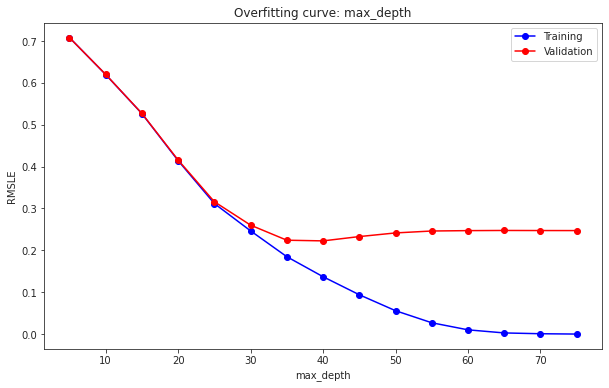

In [326]:
test_param_and_plot('max_depth', rng)

The best fit will be at `max_depth` 40 others are either overfitting or underfitting.

In [76]:
test_params(max_depth=40, min_samples_leaf=5)

(0.46, 0.552)

In [77]:
%%time
dtree_model= DecisionTreeRegressor(max_depth=40, min_samples_split=5,
                                   random_state=42, min_samples_leaf=2)
dtree_model.fit(train_inputs, train_targets)

CPU times: user 1min 41s, sys: 221 ms, total: 1min 41s
Wall time: 1min 41s


DecisionTreeRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

In [78]:
dtree_model.get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 40,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [79]:
dtm_t_preds = dtree_model.predict(train_inputs)
dtm_v_preds = dtree_model.predict(val_inputs)
print("train_error", eval_metrics(train_targets, dtm_t_preds))
print("val_error", eval_metrics(val_targets, dtm_v_preds))

train_error {'RMSLE': 0.388}
val_error {'RMSLE': 0.558}


After a lot of experimentation the score is nothing but increasing. The best score the tree model made is `validation predicts: 0.552 rmsle`. Still the score not sufficient now we're in top 300.

## <a name="ema"></a> VII. Exponential Weighted Moving Average

Moving Average (MA) is one of the most and commonly used strategy in marketing analysis. It has two types Simple Moving Average (SMA) and Exponential Moving Average (EMA). To learn more about moving average refer to this [video](https://youtu.be/Kt-6PfYg_II).


$$ EMA = [Current Sales * e] + [Previous EMA * (1-e)]$$

where:

$e = 2/(Totaldays +1)$


In [105]:
# Date Features
def create_date_features_Date(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    return df
    
# Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [106]:
# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feature_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feature_imp[0:25])
        plt.title('Important Features')
        plt.tight_layout()
        plt.show()
    else:
        print(feature_imp.head(num)) 

Let's load up the data again and add the EMA features

In [107]:
df_train = pd.read_csv("./store-sales-time-series-forecasting/train.csv",index_col=0)
df_test = pd.read_csv("./store-sales-time-series-forecasting/test.csv",index_col=0)
df_transactions = pd.read_csv("./store-sales-time-series-forecasting/transactions.csv")
df_stores = pd.read_csv("./store-sales-time-series-forecasting/stores.csv")
df_holidays = pd.read_csv("./store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")

In [108]:
import numpy as np
df_oil.dcoilwtico[0]=93.00

for i in list(df_oil[df_oil.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([df_oil.dcoilwtico[p],
                  df_oil.dcoilwtico[c]])
  df_oil.dcoilwtico[i]=mean

df_oil.dcoilwtico[1174]=46.02
df_oil.dcoilwtico[1175]=46.02
df_oil['date'] = df_oil['date'].astype("datetime64")

In [109]:
df_date = pd.DataFrame(pd.date_range("2013-01-01","2017-08-31"),columns=["date"])
df_oil = df_date.merge(df_oil,left_on='date',right_on='date',how='left').fillna(method='ffill').fillna(method='bfill')

df_all = df_train.append(df_test)
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")

df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")

df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],
                      right_on=["date","store_nbr"],how="left")

df_all["date"] = df_all["date"].astype("datetime64")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace(",","_",regex=True)
df_all = df_all.rename(columns = {"date":"Date"})

In [110]:
col = ['Date','store_nbr','family','sales','onpromotion',
       'city', 'state', 'type', 'locale_name',#
       'cluster','Holiday_type','locale','description', 
       'transferred','dcoilwtico']

df = df_all[col]

In [111]:
df["store_nbr"] = df["store_nbr"].astype("category")
df["family"] = df["family"].astype("category")
df["onpromotion"] = df["onpromotion"].astype("int64")
df["city"] = df["city"].astype("category")#
df["state"] = df["state"].astype("category")#
df["type"] = df["type"].astype("category")#
df["Holiday_type"] = df["Holiday_type"].astype("category")
df["locale"] = df["locale"].astype("category")
df["locale_name"] = df["locale_name"].astype("category")#
df["description"] = df["description"].astype("category")
df["transferred"] = df["transferred"].astype("category")

######################### 
df = create_date_features_Date(df)
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 6, 7, 8, 30]
df = ewm_features(df, alphas, lags)
#######################

df['sales'] = np.log1p(df["sales"].values) #Logarithmic Conversion 

Now we will split the data in Train/Val/Test using dates.

* Test: 1 JAN 2014 - 1 OCT 2017 (99.9%)

* Validation : 2 OCT 2017 - 15 OCT 2017 (0.1%)

* Test will be having original test dates data.

In [112]:
#Train Test Split
df= df[df["Date"]>"2013-12-31"]
val = df[(df["Date"]>"2017-08-01")&(df["Date"]<="2017-08-15")]
train  = df[df["Date"]<="2017-08-01"]
test = df[df["Date"]>"2017-08-15"]

col_X = [col for col in train.columns if col not in ['Date', 'sales','year']]

y_train = train["sales"]
y_val = val["sales"]
X_train = train[col_X]
X_val = val[col_X]
X_test = test[col_X]
y_test = test["sales"]

#### Training with LightGBM

In [113]:
# LightGBM parameters
lgb_params = {'metric': {'mse'},
              'boosting_type' : 'gbdt',
              'num_leaves': 8,
              'learning_rate': 0.2,
              #'feature_fraction': 0.8,
              'max_depth': 7,
              'verbose': 0,
              'num_boost_round': 5000,
              'early_stopping_rounds': 200,
              'nthread': -1,
             'force_col_wise':True}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=col_X)
lgbtest = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=col_X)

In [115]:
from sklearn.metrics import mean_absolute_error
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.166439	valid_1's l2: 0.16118
[400]	training's l2: 0.154959	valid_1's l2: 0.154517
[600]	training's l2: 0.148863	valid_1's l2: 0.150085
[800]	training's l2: 0.144897	valid_1's l2: 0.147121
[1000]	training's l2: 0.141795	valid_1's l2: 0.145686
[1200]	training's l2: 0.139328	valid_1's l2: 0.144042
[1400]	training's l2: 0.137468	valid_1's l2: 0.143151
[1600]	training's l2: 0.135916	valid_1's l2: 0.14223
[1800]	training's l2: 0.134467	valid_1's l2: 0.141673
[2000]	training's l2: 0.133244	valid_1's l2: 0.141175
[2200]	training's l2: 0.132152	valid_1's l2: 0.141105
[2400]	training's l2: 0.130917	valid_1's l2: 0.140761
[2600]	training's l2: 0.13001	valid_1's l2: 0.140536
[2800]	training's l2: 0.129088	valid_1's l2: 0.140448
[3000]	training's l2: 0.128313	valid_1's l2: 0.140405
[3200]	training's l2: 0.127423	valid_1's l2: 0.140173
[3400]	training's l2: 0.126713	valid_1's l2: 0.140066
[3600]	training's l2: 0.125

In [116]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val[y_pred_val<0]=0
eval_metrics(np.expm1(y_val), np.expm1(y_pred_val))

{'RMSLE': 0.374}

In [117]:
plot_lgb_importances(model, plot=True)

In [118]:
submission = pd.read_csv("./store-sales-time-series-forecasting/sample_submission.csv")
y_test = model.predict(X_test, num_iteration=model.best_iteration)
y_test[y_test<0]=0
submission["sales"] = np.expm1(y_test)

Writing the results into `final_submission` .csv file

In [119]:
submission.to_csv("final_submission.csv",index=False)
submission

id    sales
0      3000888     4.13
1      3000889     0.06
2      3000890     5.59
3      3000891 2,480.65
4      3000892     0.09
...        ...      ...
28507  3029395   408.83
28508  3029396   131.78
28509  3029397 1,832.09
28510  3029398   119.16
28511  3029399    14.88

[28512 rows x 2 columns]

Finally the score was `Test Preds 0.43 RSMLE`, that gave a jump from 300+ to Top 100

image.png

## <a name="concl"></a> VIII. Conclusion

* Base Model (Median & Mean): 
The private score for the Base model was 2.67 & 3.79

* Decision Tree Regressor: 
The public leaderboard score for the DecisionTree model was 0.72

* Exponential Moving Average: 
The public leaderboard score for the EMA was 0.43

In [123]:
# Saving the Model
import joblib

sales_forcast_ema = {
    'LightGBM_model': model,
    'input_cols': X_train.columns,
    'target_col': 'sales'}

joblib.dump(sales_forcast_ema, 'sales_forcast_ema.joblib')

#sales_forcast = joblib.load('aussie_rain.joblib')

['sales_forcast_ema.joblib']

## <a name="sum"></a> IX. Summary


This project dataset has 30M+ reocrds. Changed the datatypes of each column to reduce size of the file.

As expected the linear models didn't perform well on the other hand DecisionTree remembered the training data as it is, after tuning the results imporved a little bit. The Exponential Moving Average strategy had the most impact in model training among the other models. The results improved by applying EMA strategy and scored at Top 16% in Kaggle public leaderboard.

Date Features also had an impact on predicting sales especially `day_of_week` column.

#### Future Work

1. Implement more models to improve score like ARIMA.

2. Can extract features from the target variable such as aggregrate, rolling stats since we have time-series data.

3. Will work on Unsupurvised Machine Learning problems.

4. Work on Deep learning and NLP projects.

## <a name="ref"></a> X. Reference

**Documentaion**

[1]. Scikit Learn Supervised Learning [Doc](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  

[2]. Light GBM [Doc](https://lightgbm.readthedocs.io/en/latest/)  

[3]. XGBoost [Doc](https://xgboost.readthedocs.io/en/latest/)

[4]. RMSLE [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html)

**Tutorials**

[5]. How to approach Machine Learning Problems 
[Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp)

[6]. Exponential Moving Average: [Video](https://youtu.be/Kt-6PfYg_II)


**Blogs and Kaggle Kernels**

[7]. Algorithm to find best moving average, Gianluca Malato: [Link](https://towardsdatascience.com/an-algorithm-to-find-the-best-moving-average-for-stock-trading-1b024672299c)

[8]. Store Sales TS Forecasting - A Comprehensive Guide, EKREM BAYAR: [Link](https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook#11.-Exponential-Moving-Average)

[9]. Time Series Analysis, KASHISH RASTOGI: [Link](https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie?scriptVersionId=81112640)

[10]. More Data Info: [Link](https://rpubs.com/yongks/favorita)

[11]. Walmart Store Sales Forecasting, Anushree: [Link](https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm#C0)

[12]. Credit Default Prediction using ML, David Zhong [Link](https://jovian.ai/shenghongzhong/credit-scores-algorithms-ml-2#C1)

**Queries**

[13]. StackOverflow, GeekforGeeks

In [124]:
# Execute this to save new versions of the notebook
jovian.commit(outputs=['sales_forcast_ema.joblib'])
jovian.commit(project="store-sales-time-series-forecasting")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...
Committed successfully! https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting
[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting


'https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting'